In [101]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [102]:
df=pd.read_csv("cnn_architecture_variant_dataset.csv")

In [103]:
print(df.head())
print(df.columns)

    pixel_1   pixel_2   pixel_3   pixel_4   pixel_5   pixel_6   pixel_7  \
0  0.243204 -0.738981 -0.357734  0.557096  0.183533  0.046300  0.771281   
1  0.815918  0.096144  1.212052 -0.939903  0.324143  0.708714  0.450806   
2 -0.479936  0.307697 -0.559881 -1.383517  0.277073  0.152984  2.027055   
3  2.494252  0.194216 -0.612278  0.381748 -1.635753 -0.202883  0.234952   
4 -0.239380  0.955675 -1.097448  1.414636  0.238422 -1.221134  0.135609   

    pixel_8   pixel_9  pixel_10  ...  pixel_776  pixel_777  pixel_778  \
0  0.294460  0.687488  0.533621  ...  -0.588372   1.193028   0.001696   
1 -1.741769 -0.346139 -0.633644  ...  -0.331393  -0.259975  -0.247964   
2 -1.790058  1.021917 -0.291892  ...  -1.464524   0.288603  -0.799115   
3  0.439956 -1.986018 -0.808556  ...   0.750585  -0.372816  -2.209724   
4  1.354513  0.123703  1.273360  ...   0.319291  -0.292636   0.642624   

   pixel_779  pixel_780  pixel_781  pixel_782  pixel_783  pixel_784  label  
0  -0.557353  -1.035452   0.37092

In [104]:
pixel_columns = df.columns[:-1]
label_column = df.columns[-1]

In [105]:
print(df[label_column].isna().sum())

1


In [106]:
df = df.dropna(subset=[label_column])

In [107]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df[label_column], random_state=42)

In [108]:
class CSVDataset(Dataset):
    def __init__(self, dataframe):
        self.X = dataframe[pixel_columns].values.astype(np.float32)
        self.y = dataframe[label_column].values.astype(np.int64)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = self.X[idx].reshape(1, 28, 28) / 255.0  
        y = self.y[idx]
        return torch.tensor(x), torch.tensor(y)

In [109]:
train_dataset = CSVDataset(train_df)
test_dataset = CSVDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [110]:
class CNNModel(nn.Module):
    def __init__(self, input_shape=(1,28,28), num_filters=16, kernel_size=3, num_conv_layers=2, pooling='max', num_classes=10):
        super(CNNModel, self).__init__()
        layers = []
        in_channels = input_shape[0]
        nf = num_filters
        for i in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, nf, kernel_size=kernel_size, padding=kernel_size//2))
            layers.append(nn.ReLU())
            if pooling == 'max':
                layers.append(nn.MaxPool2d(2))
            elif pooling == 'avg':
                layers.append(nn.AvgPool2d(2))
            else:
                raise ValueError("Pooling must be 'max' or 'avg'")
            in_channels = nf
            nf *= 2
        
        self.conv = nn.Sequential(*layers)
        self._conv_output_size = self._get_conv_output_size(input_shape)
        self.fc = nn.Linear(self._conv_output_size, num_classes)
        
    def _get_conv_output_size(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = self.conv(dummy_input)
            return output.view(1, -1).size(1)
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [111]:
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
        train_losses.append(total_loss / total)
        train_accuracies.append(100. * correct / total)
        
        model.eval()
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
        test_losses.append(test_loss / total)
        test_accuracies.append(100. * correct / total)
        
        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, Test Loss={test_losses[-1]:.4f}, Test Acc={test_accuracies[-1]:.2f}%")
        
    return train_losses, train_accuracies, test_losses, test_accuracies

In [112]:
variants = [
    {'num_filters': 16, 'kernel_size': 3, 'num_conv_layers': 2, 'pooling': 'max'},
    {'num_filters': 32, 'kernel_size': 3, 'num_conv_layers': 3, 'pooling': 'max'},
    {'num_filters': 16, 'kernel_size': 5, 'num_conv_layers': 2, 'pooling': 'avg'},
    {'num_filters': 64, 'kernel_size': 3, 'num_conv_layers': 1, 'pooling': 'max'},
]

input_shape = (1, 28, 28)
results = {}

for v in variants:
    print(f"\nTraining model: filters={v['num_filters']}, kernel={v['kernel_size']}, conv_layers={v['num_conv_layers']}, pooling={v['pooling']}")
    model = CNNModel(input_shape=input_shape, **v)
    start_time = time.time()
    train_losses, train_acc, test_losses, test_acc = train_model(model, train_loader, test_loader, epochs=5)
    elapsed = time.time() - start_time
    key = f"filters={v['num_filters']}, kernel={v['kernel_size']}, layers={v['num_conv_layers']}, pool={v['pooling']}"
    results[key] = {
        'train_losses': train_losses,
        'train_acc': train_acc,
        'test_losses': test_losses,
        'test_acc': test_acc,
        'time': elapsed
    }


Training model: filters=16, kernel=3, conv_layers=2, pooling=max
Epoch 1: Train Loss=2.2999, Train Acc=11.32%, Test Loss=2.2661, Test Acc=14.29%
Epoch 2: Train Loss=2.2805, Train Acc=11.32%, Test Loss=2.2452, Test Acc=14.29%
Epoch 3: Train Loss=2.2645, Train Acc=11.32%, Test Loss=2.2280, Test Acc=21.43%
Epoch 4: Train Loss=2.2517, Train Acc=18.87%, Test Loss=2.2142, Test Acc=21.43%
Epoch 5: Train Loss=2.2424, Train Acc=18.87%, Test Loss=2.2032, Test Acc=21.43%

Training model: filters=32, kernel=3, conv_layers=3, pooling=max
Epoch 1: Train Loss=2.3041, Train Acc=7.55%, Test Loss=2.2845, Test Acc=21.43%
Epoch 2: Train Loss=2.2886, Train Acc=18.87%, Test Loss=2.2587, Test Acc=21.43%
Epoch 3: Train Loss=2.2700, Train Acc=18.87%, Test Loss=2.2273, Test Acc=21.43%
Epoch 4: Train Loss=2.2495, Train Acc=18.87%, Test Loss=2.2014, Test Acc=21.43%
Epoch 5: Train Loss=2.2374, Train Acc=18.87%, Test Loss=2.1954, Test Acc=21.43%

Training model: filters=16, kernel=5, conv_layers=2, pooling=avg
Epo

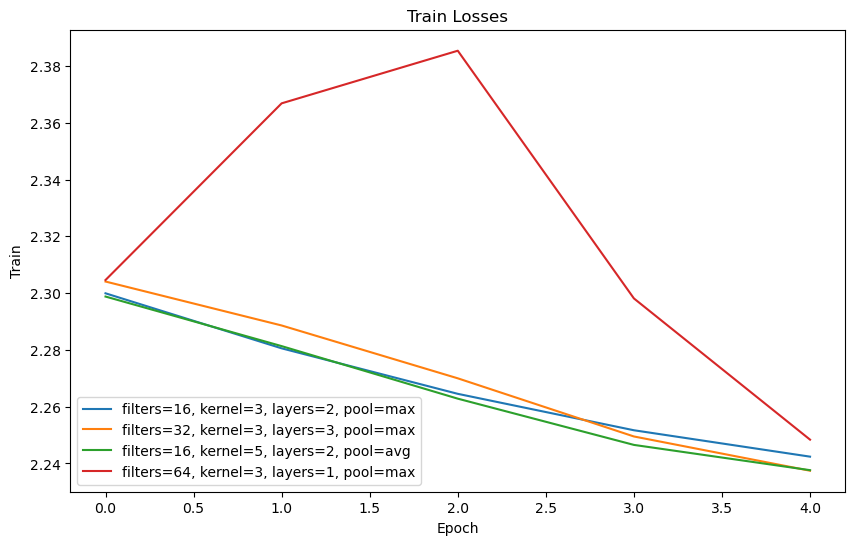

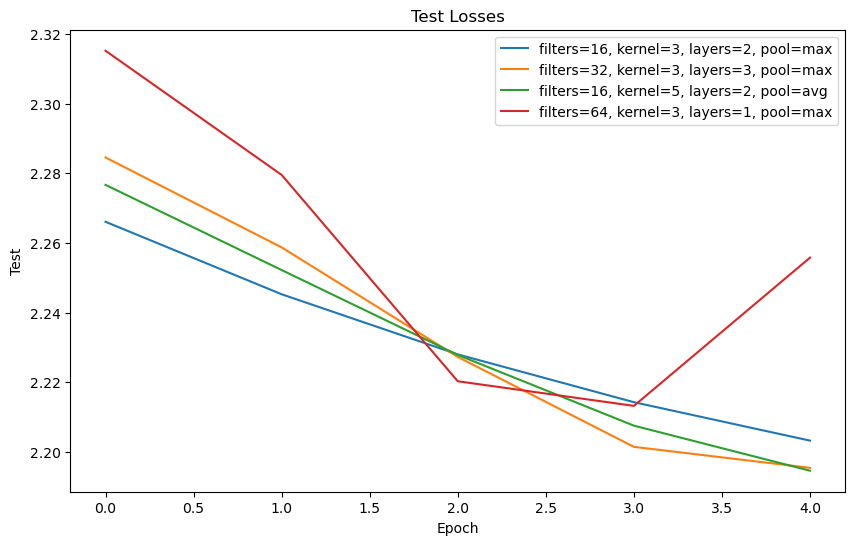

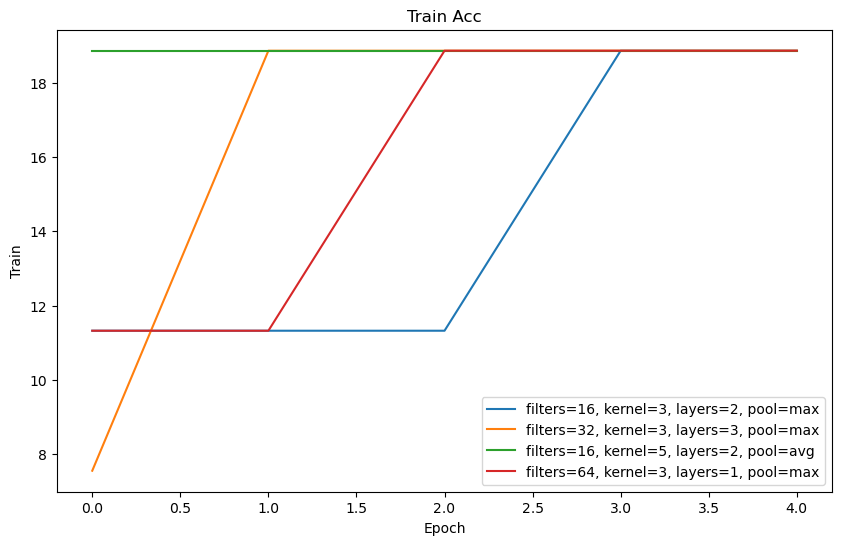

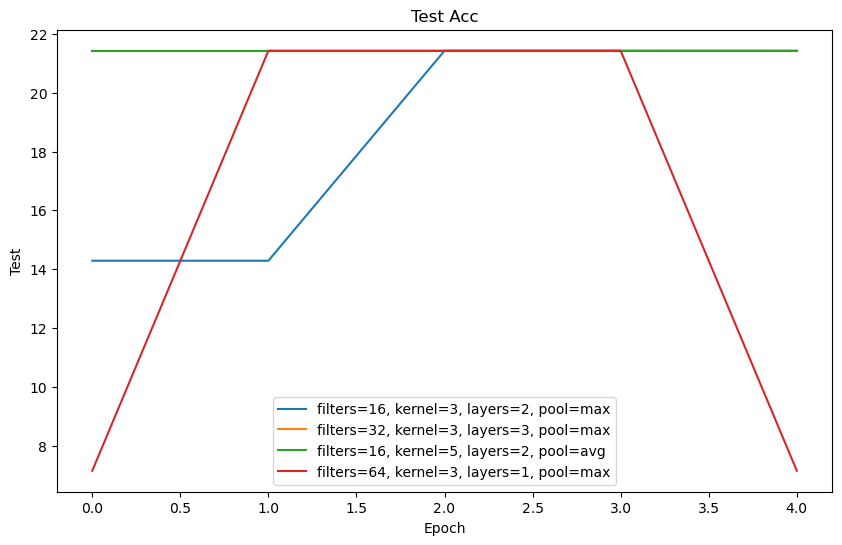

In [113]:
for metric in ['train_losses', 'test_losses', 'train_acc', 'test_acc']:
    plt.figure(figsize=(10,6))
    for key in results:
        plt.plot(results[key][metric], label=key)
    plt.title(metric.replace('_', ' ').title())
    plt.xlabel('Epoch')
    plt.ylabel(metric.split('_')[0].capitalize())
    plt.legend()
    plt.show()

In [115]:
summary_data = []
for key, res in results.items():
    summary_data.append({
        'Model': key,
        'Final Train Acc (%)': res['train_acc'][-1],
        'Final Test Acc (%)': res['test_acc'][-1],
        'Final Train Loss': res['train_losses'][-1],
        'Final Test Loss': res['test_losses'][-1],
        'Training Time (s)': round(res['time'], 2)
    })

summary_df = pd.DataFrame(summary_data)
print("\nSummary Table:")
print(summary_df)


Summary Table:
                                      Model  Final Train Acc (%)  \
0  filters=16, kernel=3, layers=2, pool=max            18.867925   
1  filters=32, kernel=3, layers=3, pool=max            18.867925   
2  filters=16, kernel=5, layers=2, pool=avg            18.867925   
3  filters=64, kernel=3, layers=1, pool=max            18.867925   

   Final Test Acc (%)  Final Train Loss  Final Test Loss  Training Time (s)  
0           21.428571          2.242380         2.203206               0.04  
1           21.428571          2.237425         2.195390               0.08  
2           21.428571          2.237621         2.194566               0.04  
3            7.142857          2.248368         2.255774               0.04  


In [116]:
print("=== Model Training Insights and Trade-offs ===\n")

print("1. Overall Accuracy:")
print("- All models have low train and test accuracies (~18-21%), close to random guessing (10%).")
print("- Indicates models are underfitting and not learning meaningful features.\n")

print("2. Overfitting vs Underfitting:")
print("- Training and test accuracies are very close, so no signs of overfitting yet.")
print("- Models need more capacity, training time, or better data to improve.\n")

print("3. Pooling Type (Max vs Average):")
print("- Minimal difference observed between max pooling and average pooling in this experiment.")
print("- Pooling choice seems less significant given current setup.\n")

print("4. Increasing Filters and Conv Layers:")
print("- Increasing filters from 16 to 64 and conv layers from 2 to 3 did NOT improve accuracy.")
print("- Possibly limited by dataset, training epochs, or model design.\n")

print("5. Kernel Size Impact:")
print("- Using larger kernel size (5) did not improve accuracy compared to 3x3 kernels.")
print("- Larger kernels increase parameters but may need more training or regularization.\n")

print("6. Trade-offs Summary:")
print("- Speed: Larger models (more filters/layers) increase training time.")
print("- Accuracy: Currently no improvement with bigger models due to underfitting.")
print("- Overfitting: Not observed; training and test accuracies are close.")
print("- Generalization: Models generalize poorly due to low accuracy on both sets.")
print("- Pooling: Max pooling recommended by default as no clear benefit from avg pooling.")
print("- Kernel Size: Prefer 3x3 kernels unless justified by dataset or task complexity.\n")


=== Model Training Insights and Trade-offs ===

1. Overall Accuracy:
- All models have low train and test accuracies (~18-21%), close to random guessing (10%).
- Indicates models are underfitting and not learning meaningful features.

2. Overfitting vs Underfitting:
- Training and test accuracies are very close, so no signs of overfitting yet.
- Models need more capacity, training time, or better data to improve.

3. Pooling Type (Max vs Average):
- Minimal difference observed between max pooling and average pooling in this experiment.
- Pooling choice seems less significant given current setup.

4. Increasing Filters and Conv Layers:
- Increasing filters from 16 to 64 and conv layers from 2 to 3 did NOT improve accuracy.
- Possibly limited by dataset, training epochs, or model design.

5. Kernel Size Impact:
- Using larger kernel size (5) did not improve accuracy compared to 3x3 kernels.
- Larger kernels increase parameters but may need more training or regularization.

6. Trade-offs 